In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    StratifiedShuffleSplit
)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    StandardScaler,
    label_binarize,
    LabelEncoder
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import clone



from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    roc_curve,
    auc
)

from yellowbrick.classifier import ROCAUC

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import VarianceThreshold

from imblearn.over_sampling import SMOTE

from yellowbrick.classifier import PrecisionRecallCurve

from yellowbrick.model_selection import LearningCurve

Unificazione di tutti i file .csv in un'unica variabile data

In [28]:
# percorso base della cartella che contiene i CSV
base_dir = Path(
    r"C:\Users\nicde\OneDrive\Desktop\Università\Ancona\DS\Data-Science\datasets"
) / "MachineLearningCSV" / "MachineLearningCVE"

# elenco ordinato di tutti i file CSV
csv_files = sorted(base_dir.glob("*.csv"))

print(f"Numero di file CSV trovati: {len(csv_files)}")

dfs = []

# lettura sequenziale dei CSV
for i, file in enumerate(csv_files, 1):
    print(f"Caricamento file {i}/{len(csv_files)} → {file.name}")
    df = pd.read_csv(file, low_memory=False)
    dfs.append(df)

# concatenazione row-wise
data = pd.concat(dfs, ignore_index=True)

# controlli rapidi
data.head()


Numero di file CSV trovati: 8
Caricamento file 1/8 → Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Caricamento file 2/8 → Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Caricamento file 3/8 → Friday-WorkingHours-Morning.pcap_ISCX.csv
Caricamento file 4/8 → Monday-WorkingHours.pcap_ISCX.csv
Caricamento file 5/8 → Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Caricamento file 6/8 → Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Caricamento file 7/8 → Tuesday-WorkingHours.pcap_ISCX.csv
Caricamento file 8/8 → Wednesday-workingHours.pcap_ISCX.csv


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Operazioni di pulizia del dataset come ad esempio, rimozione di spazi accidentali nei nomi delle colonne ed eliminazione delle righe con almeno un valore NaN

In [29]:
# Rimozione di spazi accidentali nei nomi delle colonne
data.columns = data.columns.str.strip()

# Pulizia sintattica della variabile target (Label), se presente
if "Label" in data.columns:
    data["Label"] = data["Label"].astype(str).str.strip()

# Colonne identificative o temporali non utili per EDA e ML 
# Questa versione del dataset è già priva di molte di molte colonne non utili per machine learning
cols_to_drop = [
    "Destination Port"
]

# Drop sicuro: elimina solo quelle effettivamente presenti
data.drop(columns=[c for c in cols_to_drop if c in data.columns],
          inplace=True)

# Separa le feature dalla variabile target
feature_cols = [c for c in data.columns if c != "Label"]

# Conversione a numerico: valori non convertibili → NaN
data[feature_cols] = data[feature_cols].apply(
    pd.to_numeric, errors="coerce"
) 

# Sostituzione dei valori infiniti con NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Informazioni generali sul dataset
data.info()

# Colonne con più valori NaN
data.isna().sum(axis=0).sort_values(ascending=False).head(20)

# Rimozione delle osservazioni contenenti almeno un valore NaN
data = data.dropna(axis=0)

# Controllo finale dei NaN
data.isna().sum(axis=0).sort_values(ascending=False).head(10)

# Distribuzione delle classi (multi-class target)
if "Label" in data.columns:
    data["Label"].value_counts()

# Anteprima del dataset pulito
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 78 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                int64  
 1   Total Fwd Packets            int64  
 2   Total Backward Packets       int64  
 3   Total Length of Fwd Packets  int64  
 4   Total Length of Bwd Packets  int64  
 5   Fwd Packet Length Max        int64  
 6   Fwd Packet Length Min        int64  
 7   Fwd Packet Length Mean       float64
 8   Fwd Packet Length Std        float64
 9   Bwd Packet Length Max        int64  
 10  Bwd Packet Length Min        int64  
 11  Bwd Packet Length Mean       float64
 12  Bwd Packet Length Std        float64
 13  Flow Bytes/s                 float64
 14  Flow Packets/s               float64
 15  Flow IAT Mean                float64
 16  Flow IAT Std                 float64
 17  Flow IAT Max                 int64  
 18  Flow IAT Min                 int64  
 19  

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,109,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,52,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,34,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,3,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Data Visualizzation

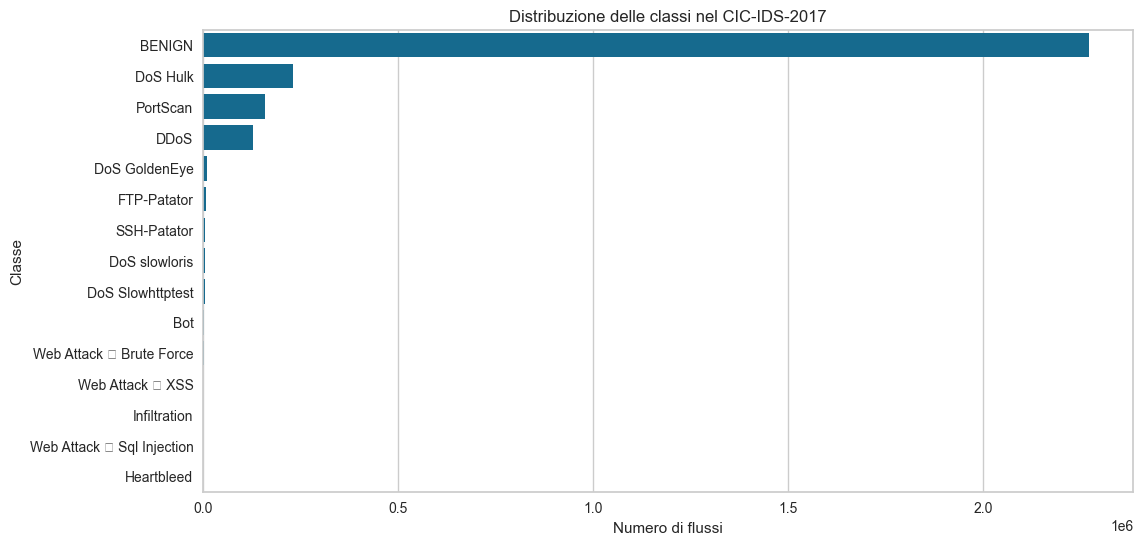

In [30]:
plt.figure(figsize=(12,6))
sns.countplot(
    y=data["Label"],
    order=data["Label"].value_counts().index
)
plt.title("Distribuzione delle classi nel CIC-IDS-2017")
plt.xlabel("Numero di flussi")
plt.ylabel("Classe")
plt.show()

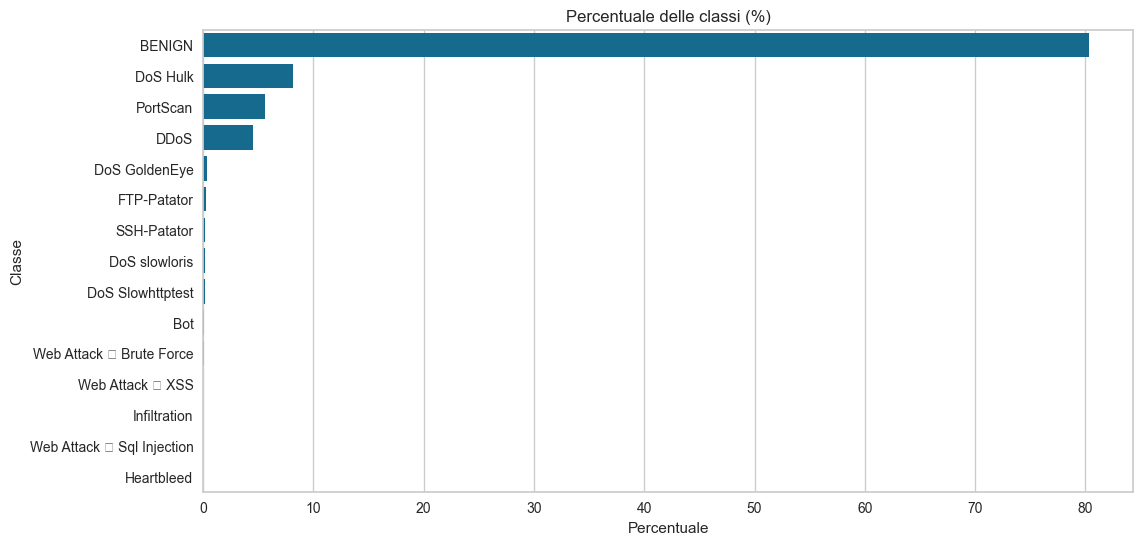

In [31]:
label_percent = data["Label"].value_counts(normalize=True) * 100

plt.figure(figsize=(12,6))
sns.barplot(
    x=label_percent.values,
    y=label_percent.index
)
plt.title("Percentuale delle classi (%)")
plt.xlabel("Percentuale")
plt.ylabel("Classe")
plt.show()

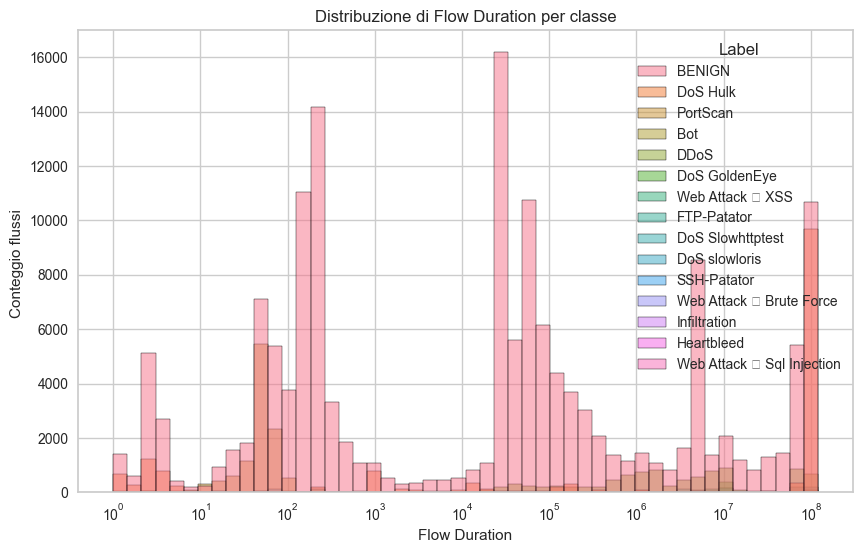

In [32]:
sample = data.sample(200_000, random_state=42)

plt.figure(figsize=(10,6))
sns.histplot(
    data=sample,
    x="Flow Duration",
    hue="Label",
    bins=50,
    kde=False,
    log_scale=True
)
plt.title("Distribuzione di Flow Duration per classe")
plt.ylabel("Conteggio flussi ")
plt.show()

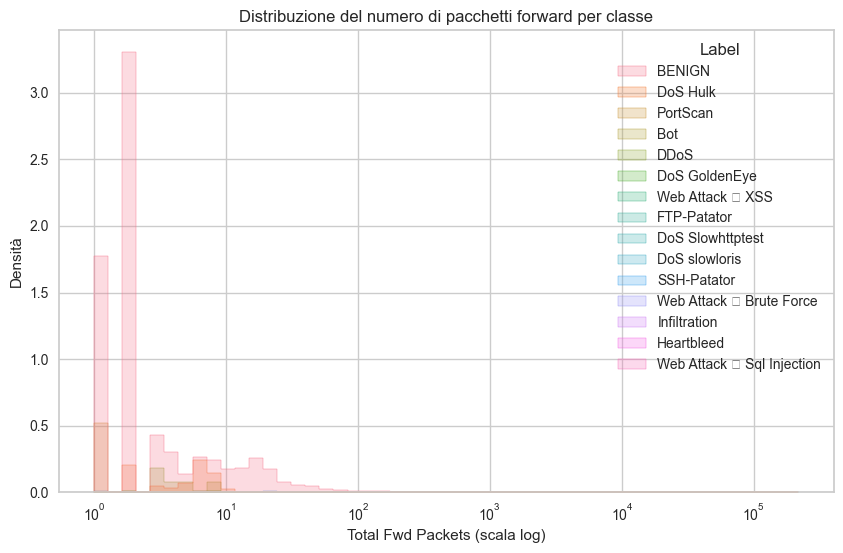

In [33]:
sample = data.sample(200_000, random_state=42)

plt.figure(figsize=(10,6))
sns.histplot(
    data=sample,
    x="Total Fwd Packets",
    hue="Label",
    bins=50,
    log_scale=True,
    element="step",
    stat="density"
)

plt.title("Distribuzione del numero di pacchetti forward per classe")
plt.xlabel("Total Fwd Packets (scala log)")
plt.ylabel("Densità")
plt.show()

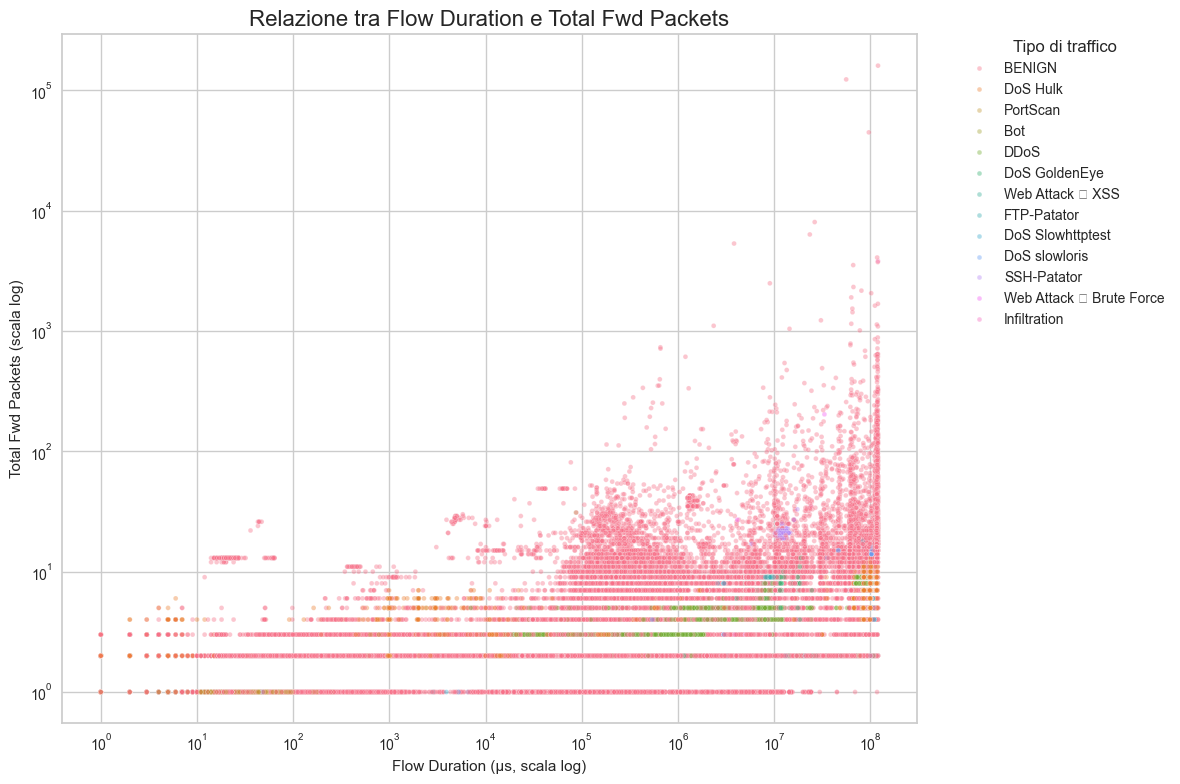

In [34]:
sample = data.sample(100_000, random_state=42)

plt.figure(figsize=(12,8))
ax = sns.scatterplot(
    data=sample,
    x="Flow Duration",
    y="Total Fwd Packets",
    hue="Label",
    alpha=0.4,
    s=12
)

ax.set_xscale("log")
ax.set_yscale("log")

plt.title("Relazione tra Flow Duration e Total Fwd Packets", fontsize=16)
plt.xlabel("Flow Duration (µs, scala log)")
plt.ylabel("Total Fwd Packets (scala log)")

# legenda spostata fuori
plt.legend(
    title="Tipo di traffico",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

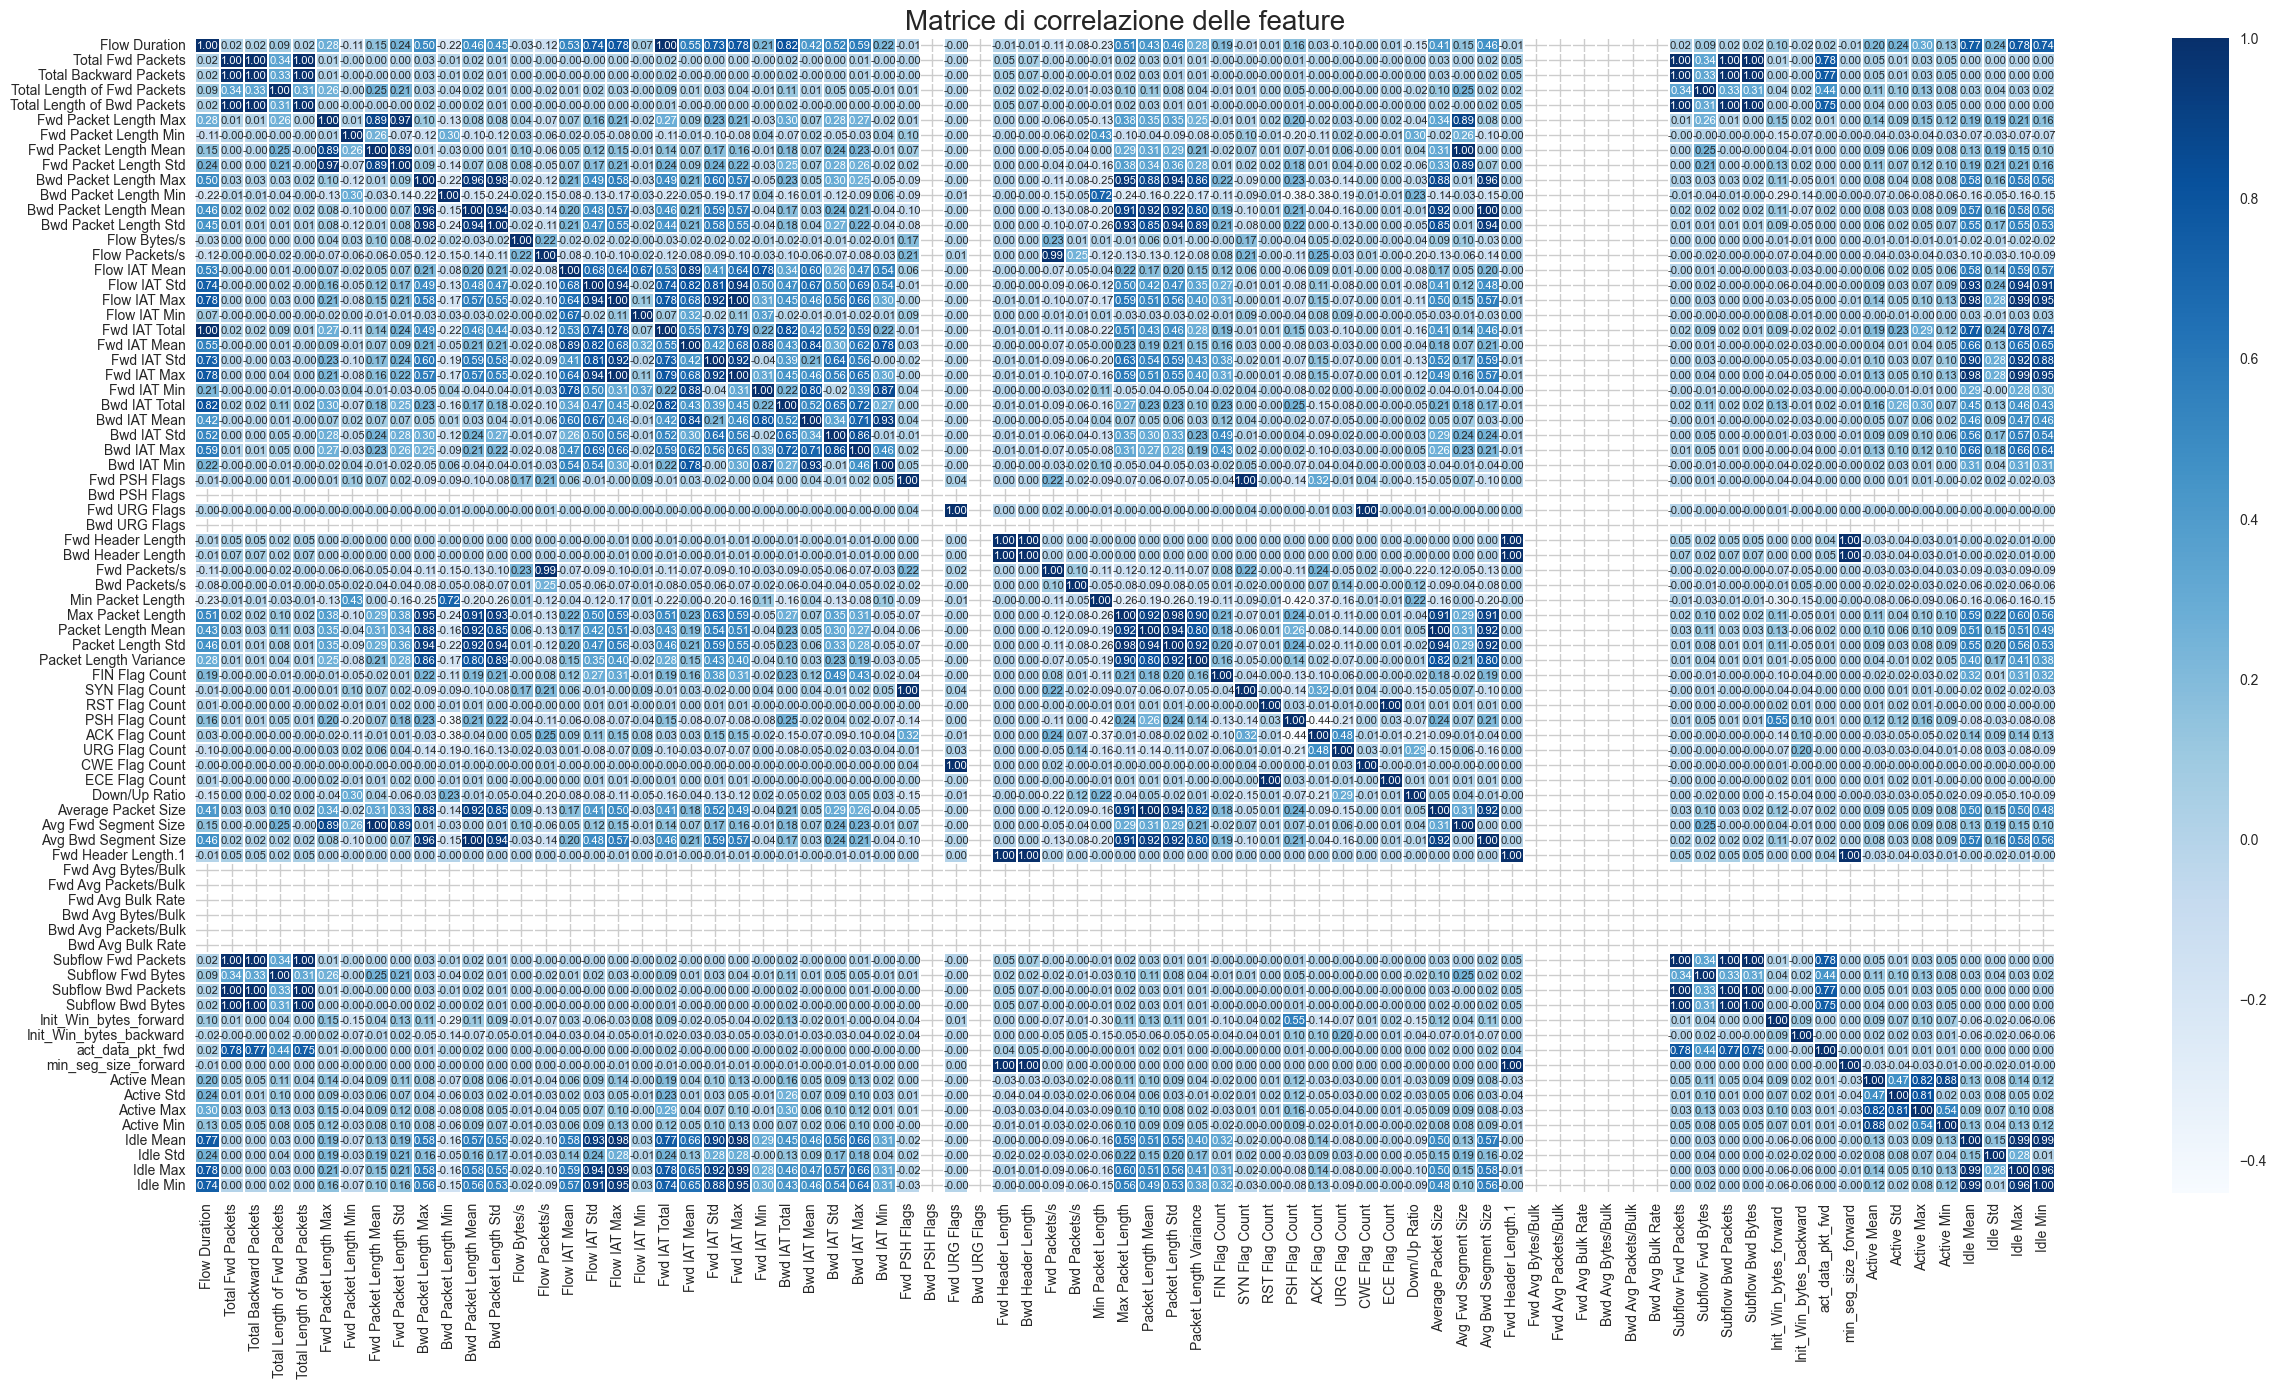

In [35]:
# Campionamento per rendere il calcolo sostenibile 
sample = data.sample(100_000, random_state=42) 
# Calcolo matrice di correlazione 
corr_matrix = sample.drop(columns=["Label"]).corr() 
plt.figure(figsize=(30, 15)) 
ax = sns.heatmap( 
        corr_matrix, 
        cmap="Blues", 
        annot=True, 
        fmt=".2f", 
        annot_kws={"size": 8}, 
        linewidths=0.3 
    ) 
plt.title("Matrice di correlazione delle feature", fontsize=20) 
plt.show()

Preprocessing

In [36]:
X = data.drop(columns=["Label"])
y = data["Label"]

print(y.value_counts())

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [37]:
#Raggruppamento classi
data.loc[data['Label'].str.contains('Web Attack', case=False, na=False), 'Label'] = 'Web_Attack'
data.loc[data['Label'].str.contains('Infiltration|Heartbleed', case=False, na=False), 'Label'] = 'Other_Attack'

# Separazione  X e y
X = data.drop(columns=["Label"])
y = data["Label"]

print("Distribuzione dopo il raggruppamento:")
print(y.value_counts())

Distribuzione dopo il raggruppamento:
Label
BENIGN              2271320
DoS Hulk             230124
PortScan             158804
DDoS                 128025
DoS GoldenEye         10293
FTP-Patator            7935
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Web_Attack             2180
Bot                    1956
Other_Attack             47
Name: count, dtype: int64


Undersampling

In [38]:
target_benign = 300_000
rng = 42

benign_mask = (data["Label"] == "BENIGN")
benign_df = data[benign_mask]
other_df  = data[~benign_mask]

if len(benign_df) > target_benign:
    benign_down = benign_df.sample(n=target_benign, random_state=rng)
else:
    benign_down = benign_df

balanced_d = pd.concat([other_df, benign_down], axis=0)\
               .sample(frac=1, random_state=rng)\
               .reset_index(drop=True)

print("Distribuzione dopo undersampling BENIGN:")
print(balanced_d["Label"].value_counts())

Distribuzione dopo undersampling BENIGN:
Label
BENIGN              300000
DoS Hulk            230124
PortScan            158804
DDoS                128025
DoS GoldenEye        10293
FTP-Patator           7935
SSH-Patator           5897
DoS slowloris         5796
DoS Slowhttptest      5499
Web_Attack            2180
Bot                   1956
Other_Attack            47
Name: count, dtype: int64


In [41]:
#Separazione X e y sul dataset dopo l'undersampling
X = balanced_d.drop(columns=["Label"])
y = balanced_d["Label"]

In [42]:
#Si svolge l'encoding in modo da convertire le etichette testuali in numeriche, oltre a facilitare la successsiva operazione
#di oversampling con SMOTE
le = LabelEncoder()
y_enc = le.fit_transform(y)

#Mappatura classe
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping

{'BENIGN': 0,
 'Bot': 1,
 'DDoS': 2,
 'DoS GoldenEye': 3,
 'DoS Hulk': 4,
 'DoS Slowhttptest': 5,
 'DoS slowloris': 6,
 'FTP-Patator': 7,
 'Other_Attack': 8,
 'PortScan': 9,
 'SSH-Patator': 10,
 'Web_Attack': 11}

Oversampling

In [43]:
sampling_strategy_enc = {
    label_mapping['Other_Attack']: 5000,
    label_mapping['Web_Attack']: 15000,
    label_mapping['Bot']: 10000,
    label_mapping['DoS slowloris']: 12000,
    label_mapping['DoS Slowhttptest']: 12000,
    label_mapping['SSH-Patator']: 15000,
    label_mapping['FTP-Patator']: 15000
}

smote = SMOTE(
    sampling_strategy=sampling_strategy_enc,
    random_state=42,
    k_neighbors=3
)

X_res, y_res_enc = smote.fit_resample(X, y_enc)
print("Distribuzione dopo SMOTE:")
print(pd.Series(y_res_enc).value_counts())


Distribuzione dopo SMOTE:
0     300000
4     230124
9     158804
2     128025
7      15000
11     15000
10     15000
6      12000
5      12000
3      10293
1      10000
8       5000
Name: count, dtype: int64


Matrice di correlazione

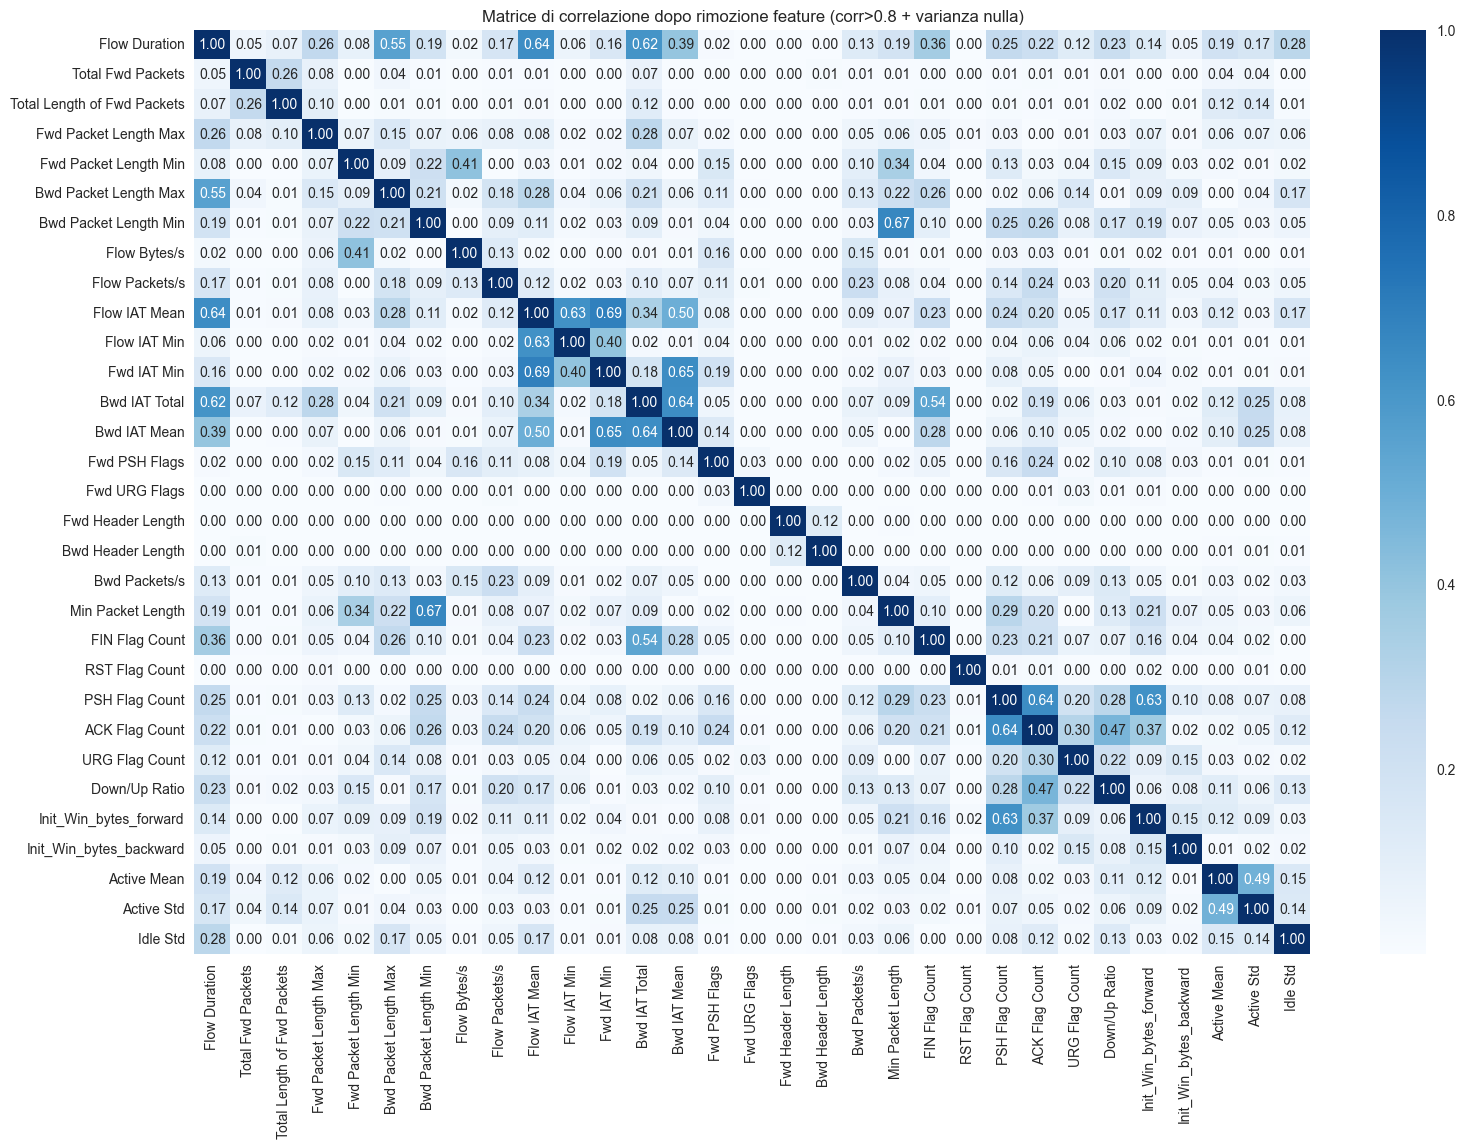

In [44]:
corr_matrix = X_res.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] >= 0.79)]

X_red = X_res.drop(columns=to_drop)


#  Rimozione feature a varianza zero
vt = VarianceThreshold(threshold=0.0)
X_final_array = vt.fit_transform(X_red)

kept_cols = X_red.columns[vt.get_support()]
dropped_zero_var = X_red.columns[~vt.get_support()]
X_final = pd.DataFrame(X_final_array, columns=kept_cols, index=X_red.index)


# Correlazione finale 
corr_matrix_final = X_final.corr().abs()

plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix_final,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}
)
plt.title("Matrice di correlazione dopo rimozione feature (corr>0.8 + varianza nulla)")
plt.show()

CLASSIFICATION

In [45]:
#Suddivisione in train e test set
rs = 42

# X_final: dataframe feature finale
# y_res_enc: target numerico dopo SMOTE
X_clf = X_final
y_clf = y_res_enc 

x_train, x_test, y_train, y_test = train_test_split(
    X_clf, y_clf,
    test_size=0.2,
    random_state=rs,
    stratify=y_clf
)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(728996, 31) (182250, 31) (728996,) (182250,)


In [46]:
rs = 42

# Definizione dei classificatori da testare
classifiers = [
    ("LogisticRegression", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=rs))
    ])),

    ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=rs)),

    ("RandomForestClassifier", RandomForestClassifier(random_state=rs)),

    ("AdaBoostClassifier", AdaBoostClassifier(random_state=rs)),

    ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=rs)),

    ("LinearDiscriminantAnalysis", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearDiscriminantAnalysis())
    ])),

    ("SVC", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(random_state=rs))  
    ]))
]

clf_name = []            # nomi modelli

clf_name_cv = []
cv_f1macro = []
cv_f1macro_std = []

cnfm = []                # confusion matrix sul test
clr = []                 # classification report sul test

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)


model_results = pd.DataFrame({"true_label": y_test})
print(type(model_results))

<class 'pandas.core.frame.DataFrame'>


Training

In [47]:
# Training
for name, clf in classifiers:
    clf_name.append(name)
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    model_results[name] = y_pred
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred, digits=4))

    print(f"{name} | Accuracy: {acc:.4f} | F1_macro: {f1m:.4f}")

LogisticRegression | Accuracy: 0.9263 | F1_macro: 0.7816
DecisionTreeClassifier | Accuracy: 0.9983 | F1_macro: 0.9953
RandomForestClassifier | Accuracy: 0.9987 | F1_macro: 0.9966
AdaBoostClassifier | Accuracy: 0.5300 | F1_macro: 0.2507
GradientBoostingClassifier | Accuracy: 0.9954 | F1_macro: 0.9818
LinearDiscriminantAnalysis | Accuracy: 0.7471 | F1_macro: 0.5505
SVC | Accuracy: 0.9597 | F1_macro: 0.9142


In [48]:
#Dato che i migliori risultati sono stati ottenuti con RandomForestClassifier e DecisionTreeClassifier,
#si esegue la cross-validation solo su questi due modelli dato che farla per tutti richiede troppo tempo
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
selected_for_cv = ["RandomForestClassifier", "DecisionTreeClassifier", "GradientBoostingClassifier"]

for name, clf in classifiers:
    if name not in selected_for_cv:
        continue

    # cross-validation sulla metrica più importante (multi-classe): f1_macro
    scores_f1 = cross_val_score(
        clf,
        x_train,
        y_train,
        scoring="f1_macro",
        cv=kfold,
        n_jobs=-1
    )

    clf_name_cv.append(name)
    cv_f1macro.append(scores_f1.mean())
    cv_f1macro_std.append(scores_f1.std())

    print(f"{name} | CV F1_macro: {scores_f1.mean():.4f} ± {scores_f1.std():.4f}")

DecisionTreeClassifier | CV F1_macro: 0.9943 ± 0.0001
RandomForestClassifier | CV F1_macro: 0.9965 ± 0.0001
GradientBoostingClassifier | CV F1_macro: 0.9811 ± 0.0154


In [49]:
results_df = pd.DataFrame({
    "model": clf_name_cv,
    "cv_f1_macro_mean": cv_f1macro,
    "cv_f1_macro_std": cv_f1macro_std
}).sort_values(by="cv_f1_macro_mean", ascending=False)

results_df

,model,cv_f1_macro_mean,cv_f1_macro_std
1,RandomForestClassifier,0.996545,0.000107
0,DecisionTreeClassifier,0.994266,0.000099
2,GradientBoostingClassifier,0.981126,0.015385


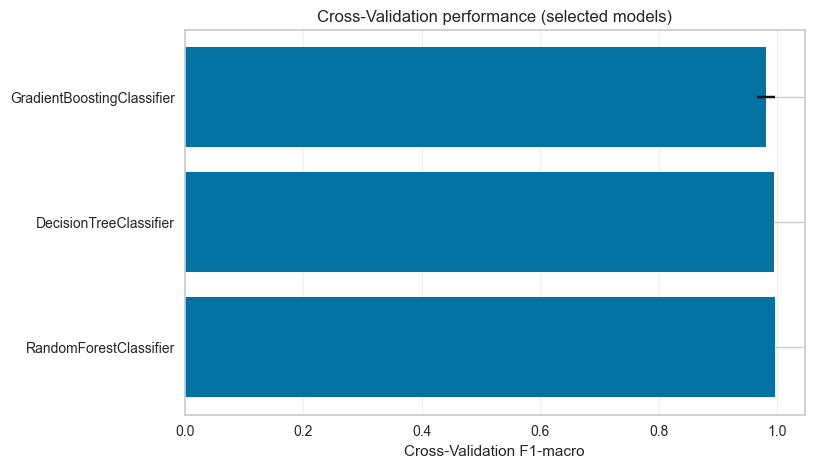

In [50]:
cv_plot_df = results_df.copy()

plt.figure(figsize=(8, 5))
plt.barh(
    cv_plot_df["model"],
    cv_plot_df["cv_f1_macro_mean"],
    xerr=cv_plot_df["cv_f1_macro_std"],
    capsize=5
)

plt.xlabel("Cross-Validation F1-macro")
plt.title("Cross-Validation performance (selected models)")
plt.grid(axis="x", alpha=0.3)
plt.show()

In [51]:
print("len(classifiers):", len(classifiers))
print("len(cnfm):", len(cnfm))
print("len(clf_name):", len(clf_name))

len(classifiers): 7
len(cnfm): 7
len(clf_name): 7


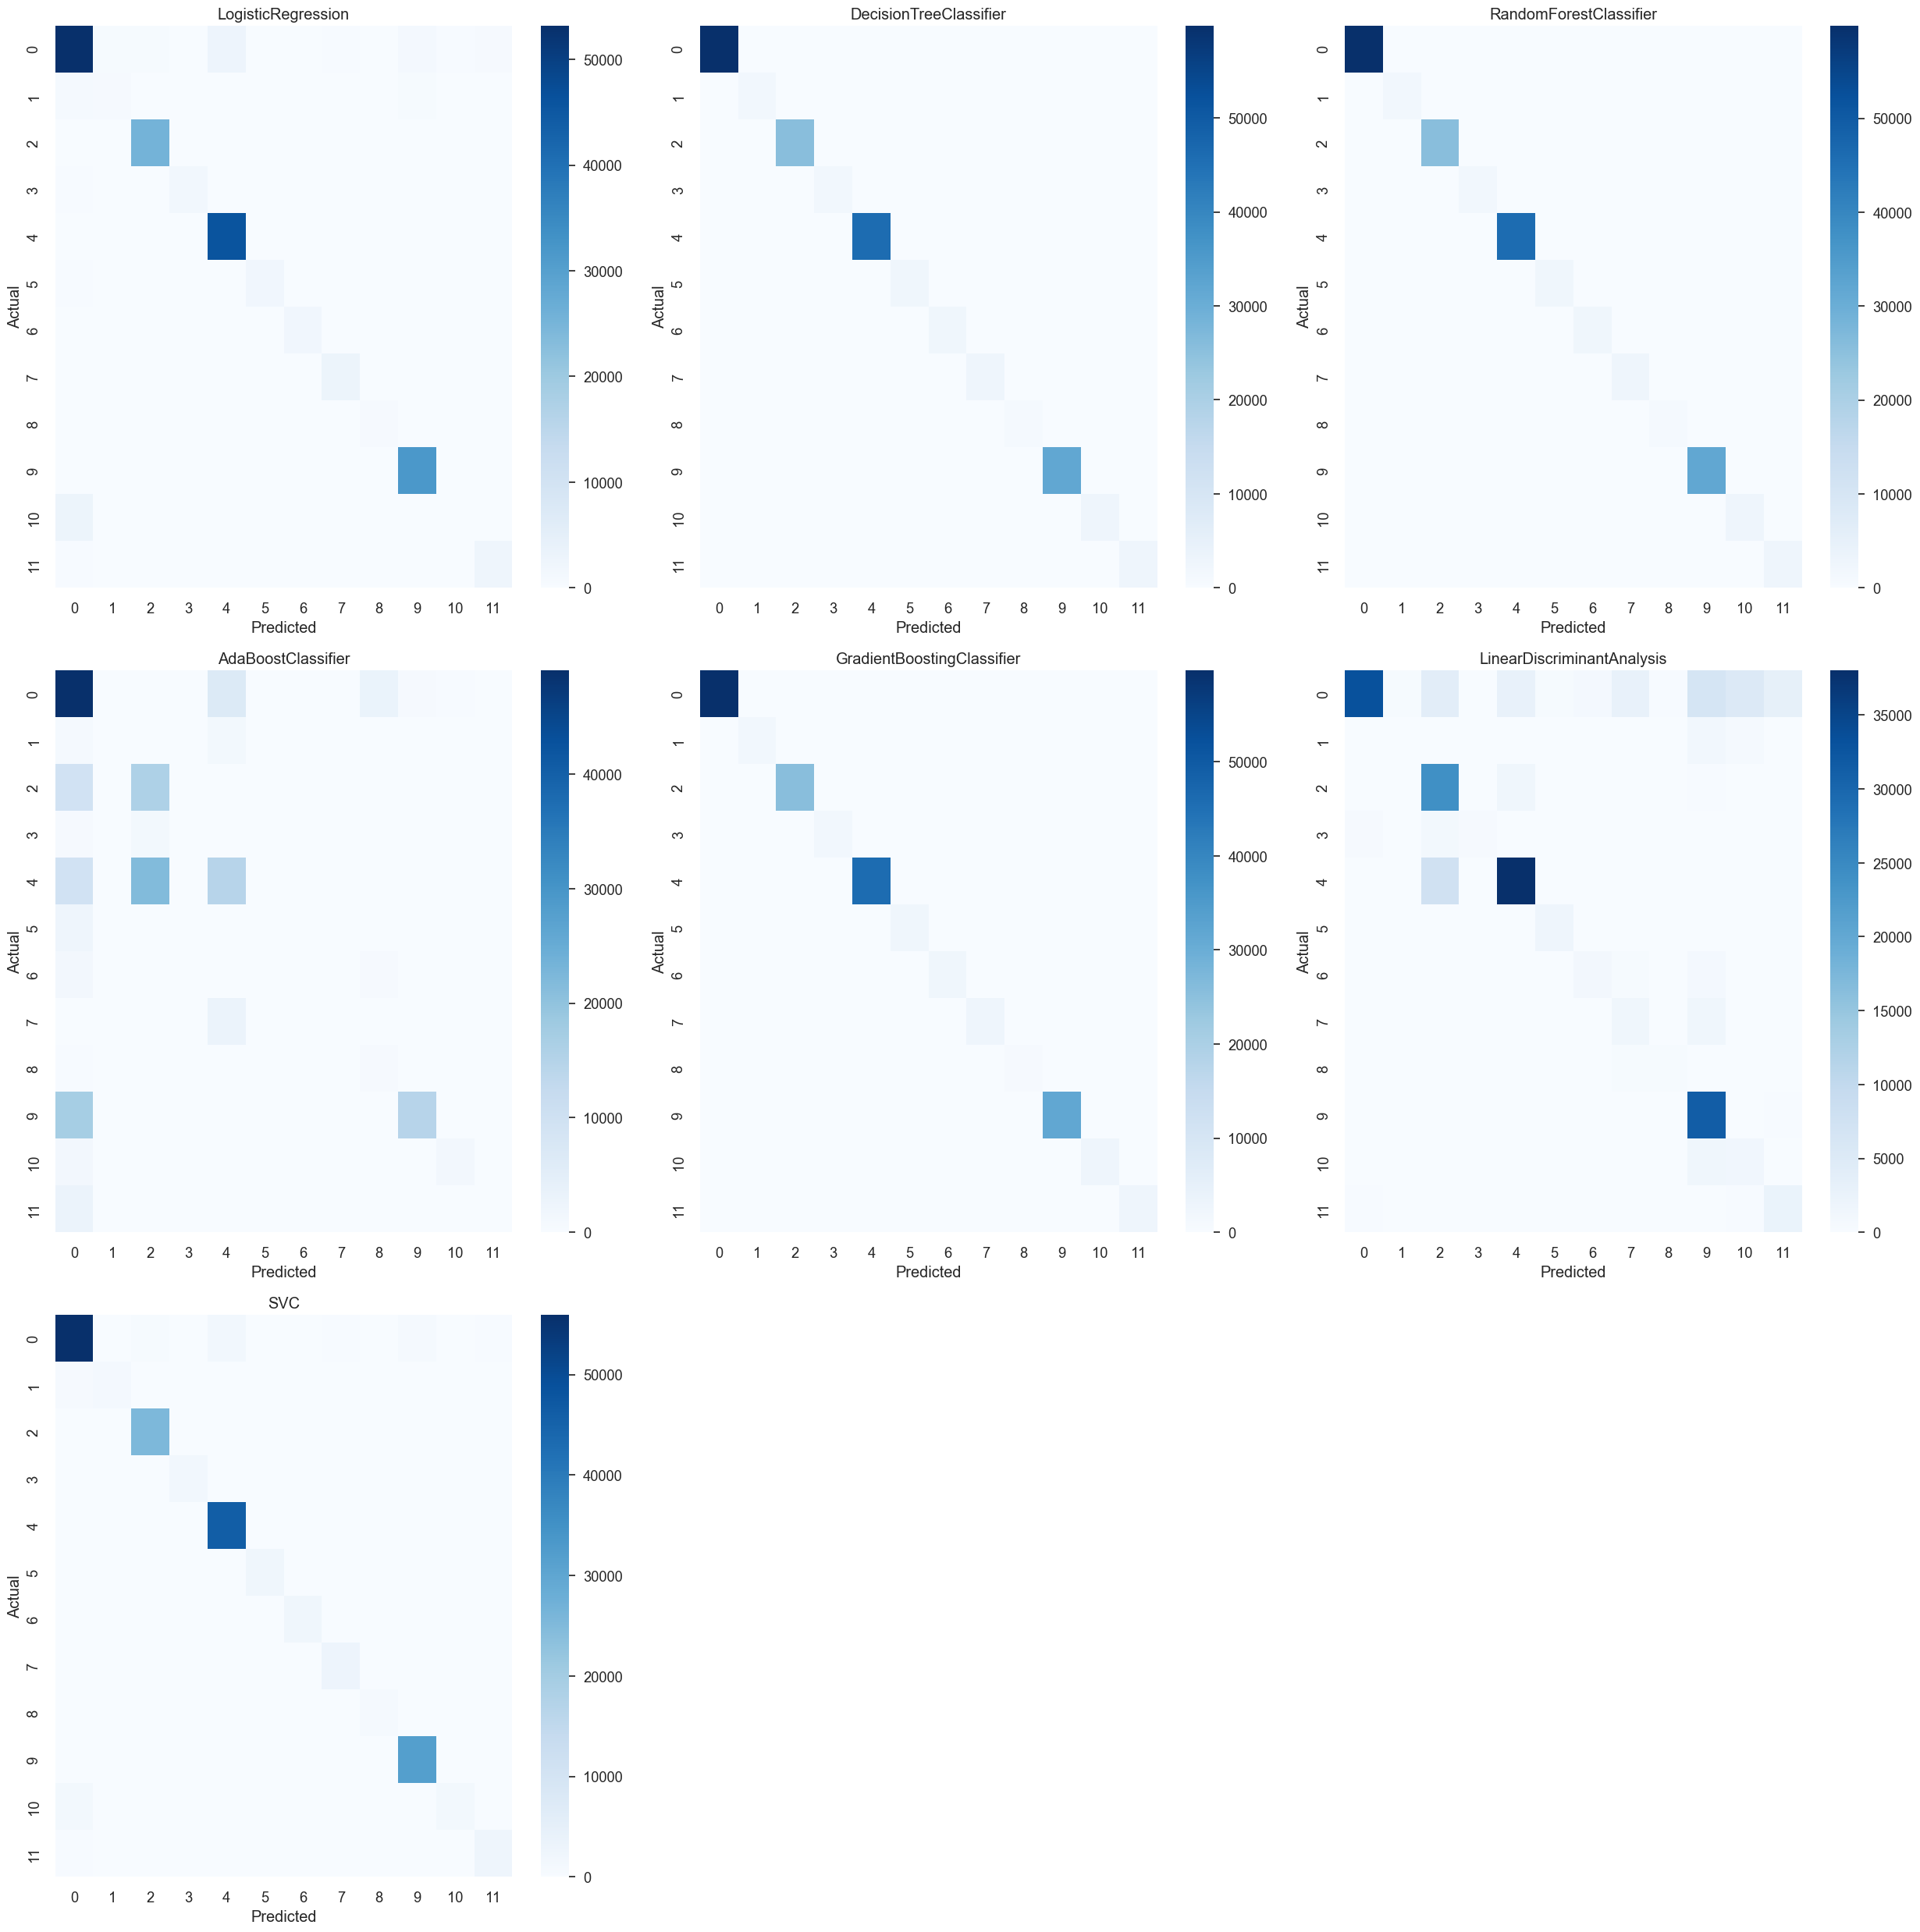

In [52]:
# Visualizzazione delle confusion matrix
plt.figure(figsize=(25,25))
sns.set(font_scale=1.2)

for i in range(len(classifiers)):
    plt.subplot(3, 3, i+1)
    sns.heatmap(cnfm[i], annot=False, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(clf_name[i])

plt.tight_layout()
plt.show()

In [53]:
# Classification Report dettagliato per ogni modello
target_names = list(le.classes_)

for i, (name, clf) in enumerate(classifiers):
    y_pred = model_results[name].values
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names, digits=4))
    print("-"*80)

LogisticRegression Classification Report:
                  precision    recall  f1-score   support

          BENIGN     0.9076    0.8870    0.8972     60000
             Bot     0.5434    0.3130    0.3972      2000
            DDoS     0.9802    0.9979    0.9889     25605
   DoS GoldenEye     0.8951    0.8538    0.8740      2059
        DoS Hulk     0.9390    0.9943    0.9659     46025
DoS Slowhttptest     0.9242    0.8175    0.8676      2400
   DoS slowloris     0.8977    0.8187    0.8564      2400
     FTP-Patator     0.8456    0.9873    0.9110      3000
    Other_Attack     0.8794    0.8020    0.8389      1000
        PortScan     0.9506    0.9953    0.9724     31761
     SSH-Patator     0.0000    0.0000    0.0000      3000
      Web_Attack     0.7596    0.8670    0.8098      3000

        accuracy                         0.9263    182250
       macro avg     0.7935    0.7778    0.7816    182250
    weighted avg     0.9106    0.9263    0.9176    182250

---------------------------

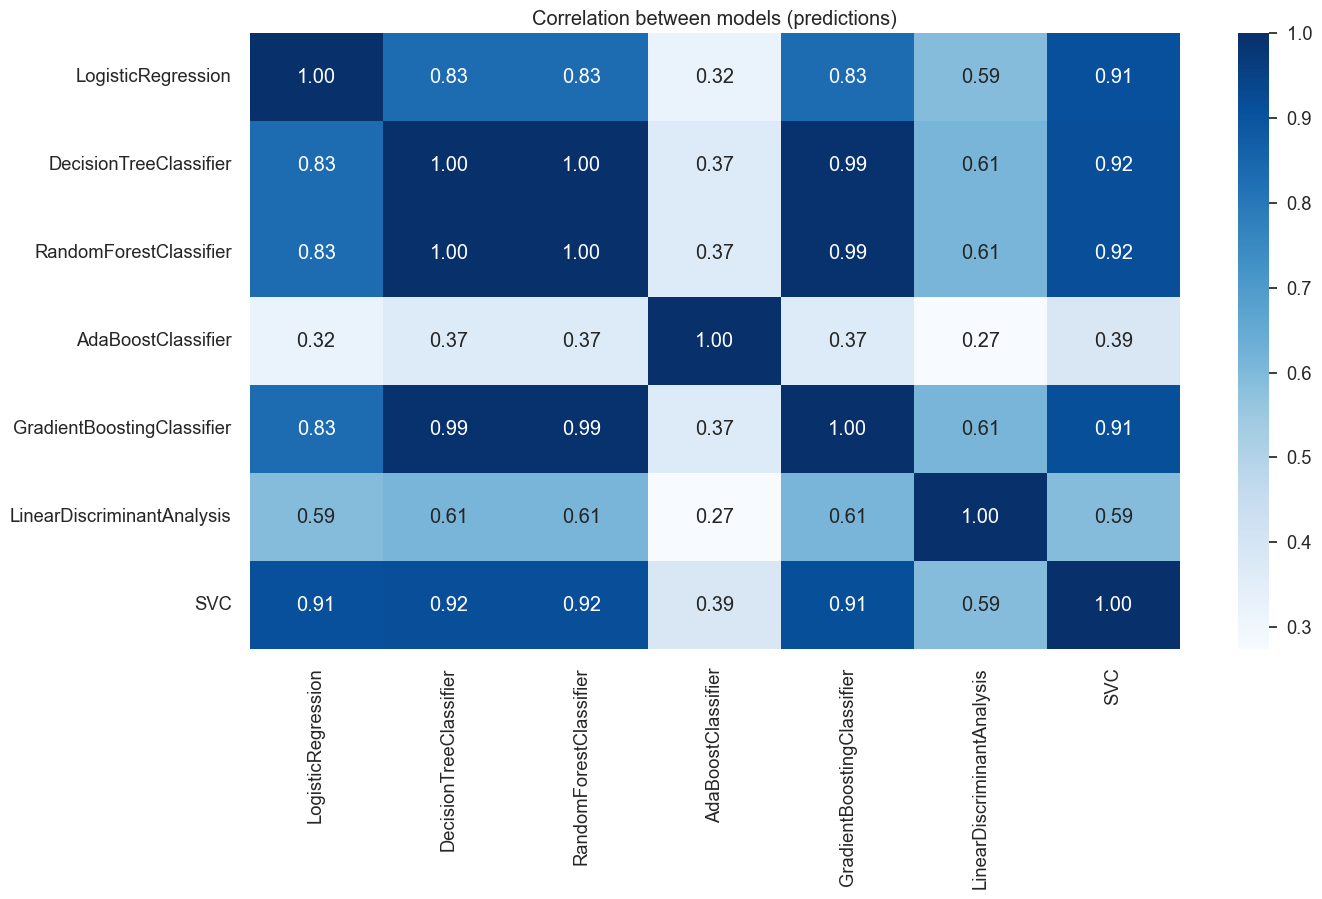

In [54]:
#Correlazione tra le predizioni dei modelli
plt.figure(figsize=(15,8))
sns.heatmap(
    model_results.drop(columns=["true_label"]).corr(),
    annot=True,
    cmap="Blues",
    fmt=".2f"
)
plt.title("Correlation between models (predictions)")
plt.show()



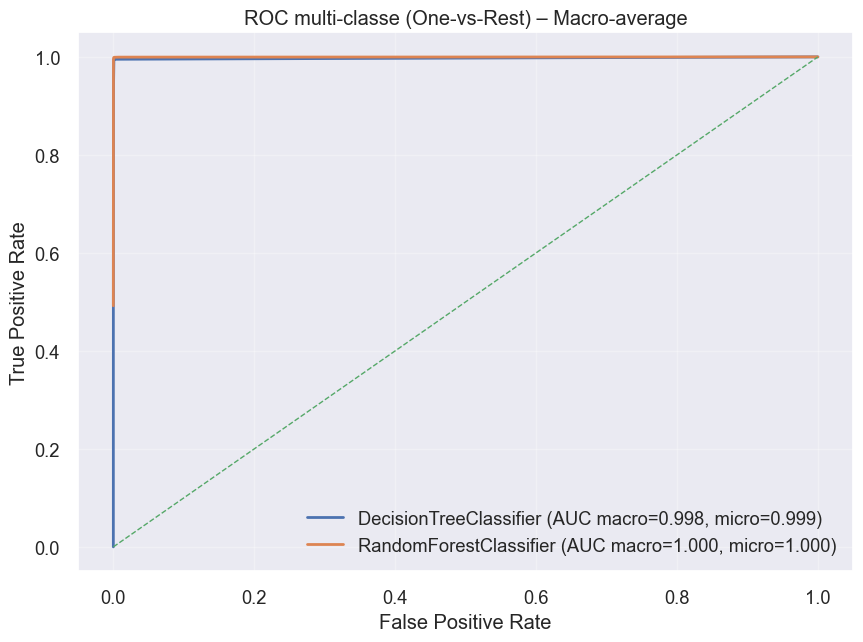

In [55]:
#ROC multi-classe 
# Classi presenti
classes = np.unique(y_train)

# Binarizzazione (OvR): y_test diventa matrice (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Seleziona i 2 modelli migliori 
selected = ["RandomForestClassifier", "DecisionTreeClassifier"]

plt.figure(figsize=(10, 7))

for name, clf in classifiers:
    if name not in selected:
        continue

    # Per sicurezza clona e rifitta 
    model = clone(clf).fit(x_train, y_train)

    # Score per ROC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(x_test)  
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(x_test)
        # alcuni modelli possono restituire shape (n_samples,) in binario; qui è multi-classe quindi atteso (n_samples, n_classes)
    else:
        raise ValueError(f"{name} non supporta predict_proba né decision_function: ROC non calcolabile.")

    # ROC micro-average
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)

    # ROC macro-average:
    # ROC per ogni classe
    fpr = {}
    tpr = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

    # unione di tutti i punti FPR
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # interpolazione e media
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)

    auc_macro = auc(all_fpr, mean_tpr)

    # Plot macro-average (una curva per modello)
    plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC macro={auc_macro:.3f}, micro={auc_micro:.3f})")

# diagonale random
plt.plot([0, 1], [0, 1], linestyle="--", lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC multi-classe (One-vs-Rest) – Macro-average")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

GREED SEARCH

In [56]:
rs = 42
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs)

# GRID SEARCH RANDOM FOREST
RF_param = {
    "n_estimators": [100, 200],
    "max_depth": [None, 20, 40],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

RFgs = GridSearchCV(
    estimator=RandomForestClassifier(random_state=rs, n_jobs=-1),
    param_grid=RF_param,
    cv=kfold,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

print("\nGrid Search per RandomForest (FULL TRAIN)")
RFgs.fit(x_train, y_train)

best_models = {}
best_scores = {}

best_models["RandomForest"] = RFgs.best_estimator_
best_scores["RandomForest"] = RFgs.best_score_

print("Best params RF:", RFgs.best_params_)
print("Best CV F1_macro RF:", round(RFgs.best_score_, 4))



# GRID SEARCH GRADIENT BOOSTING (subset stratificato)
GB_param = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0]
}

GBgs = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=rs),
    param_grid=GB_param,
    cv=kfold,                 
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

# Subset stratificato dal train (per ridurre i tempi)
n_sub = 100_000  
sss = StratifiedShuffleSplit(n_splits=1, train_size=n_sub, random_state=rs)
idx_sub, _ = next(sss.split(x_train, y_train))

# X_sub: gestisce DataFrame
if hasattr(x_train, "iloc"):
    X_sub = x_train.iloc[idx_sub]
else:
    X_sub = x_train[idx_sub]

# y_sub: gestisce Series
if hasattr(y_train, "iloc"):
    y_sub = y_train.iloc[idx_sub]
else:
    y_sub = y_train[idx_sub]

print(f"\nGrid Search per GradientBoosting (SUBSET stratificato: {n_sub} righe)")
GBgs.fit(X_sub, y_sub)

best_models["GradientBoosting"] = GBgs.best_estimator_
best_scores["GradientBoosting"] = GBgs.best_score_

print("Best params GB:", GBgs.best_params_)
print("Best CV F1_macro GB (subset):", round(GBgs.best_score_, 4))


# CONFRONTO BASELINE vs GRID SEARCH (F1_macro)
print("\n=== CONFRONTO BASELINE vs GRID SEARCH (F1_macro) ===")

baseline_rf = results_df.loc[
    results_df["model"] == "RandomForestClassifier", "cv_f1_macro_mean"
].values[0]

baseline_gb = results_df.loc[
    results_df["model"] == "GradientBoostingClassifier", "cv_f1_macro_mean"
].values[0]

print("Baseline RF F1_macro:", round(baseline_rf, 4))
print("Tuned RF F1_macro:", round(best_scores["RandomForest"], 4))

print("\nBaseline GB F1_macro:", round(baseline_gb, 4))
print("Tuned GB F1_macro (subset CV):", round(best_scores["GradientBoosting"], 4))


Grid Search per RandomForest (FULL TRAIN)
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best params RF: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1_macro RF: 0.9966

Grid Search per GradientBoosting (SUBSET stratificato: 100000 righe)
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params GB: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best CV F1_macro GB (subset): 0.9913

=== CONFRONTO BASELINE vs GRID SEARCH (F1_macro) ===
Baseline RF F1_macro: 0.9965
Tuned RF F1_macro: 0.9966

Baseline GB F1_macro: 0.9811
Tuned GB F1_macro (subset CV): 0.9913



=== RandomForest (TUNED) - TEST SET ===
Accuracy: 0.9987
F1_macro:  0.9966

Classification report:
              precision    recall  f1-score   support

           0     0.9985    0.9983    0.9984     60000
           1     0.9850    0.9825    0.9837      2000
           2     0.9999    0.9996    0.9998     25605
           3     0.9951    0.9951    0.9951      2059
           4     0.9991    0.9997    0.9994     46025
           5     0.9950    0.9933    0.9942      2400
           6     0.9967    0.9954    0.9960      2400
           7     0.9997    0.9993    0.9995      3000
           8     1.0000    0.9990    0.9995      1000
           9     0.9989    0.9997    0.9993     31761
          10     1.0000    0.9987    0.9993      3000
          11     0.9977    0.9927    0.9952      3000

    accuracy                         0.9987    182250
   macro avg     0.9971    0.9961    0.9966    182250
weighted avg     0.9987    0.9987    0.9987    182250



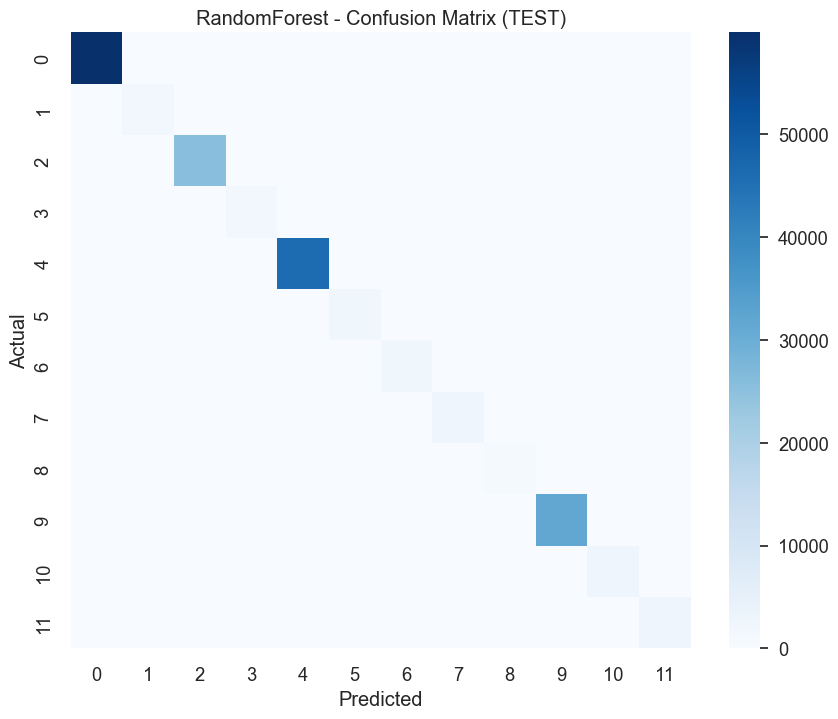


=== GradientBoosting (TUNED) - TEST SET ===
Accuracy: 0.9987
F1_macro:  0.9961

Classification report:
              precision    recall  f1-score   support

           0     0.9984    0.9982    0.9983     60000
           1     0.9840    0.9860    0.9850      2000
           2     0.9998    0.9995    0.9997     25605
           3     0.9942    0.9951    0.9947      2059
           4     0.9994    0.9998    0.9996     46025
           5     0.9941    0.9904    0.9923      2400
           6     0.9958    0.9950    0.9954      2400
           7     0.9993    1.0000    0.9997      3000
           8     0.9960    0.9930    0.9945      1000
           9     0.9989    0.9997    0.9993     31761
          10     0.9993    0.9983    0.9988      3000
          11     0.9980    0.9930    0.9955      3000

    accuracy                         0.9987    182250
   macro avg     0.9964    0.9957    0.9961    182250
weighted avg     0.9987    0.9987    0.9987    182250



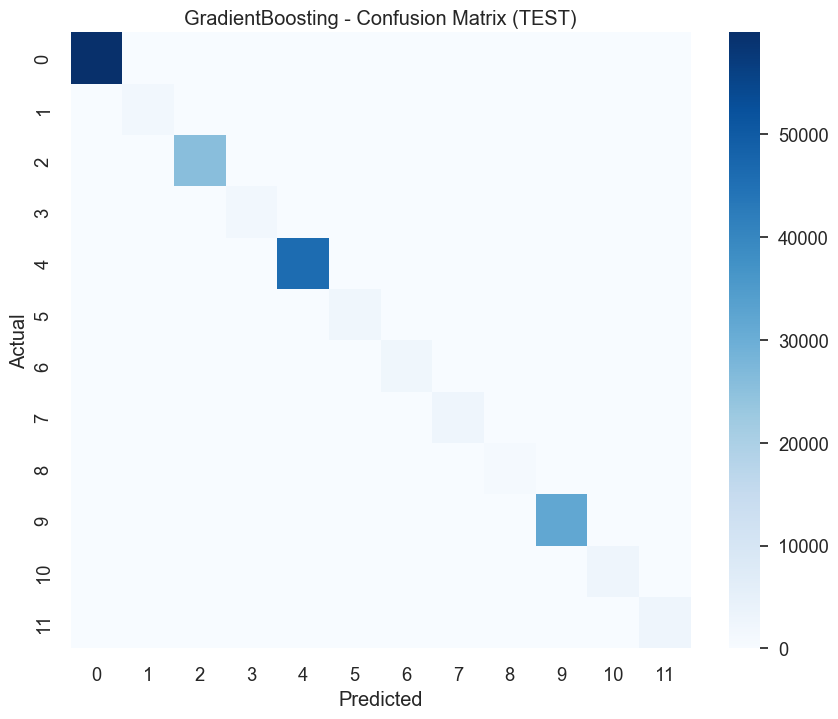

,model,test_accuracy,test_f1_macro
0,RandomForest,0.998694,0.996616
1,GradientBoosting,0.998656,0.996060


In [57]:
# Validazione finale sui modelli ottimizzati
final_results = []

for name in ["RandomForest", "GradientBoosting"]:
    model = best_models[name]

    #rifit su tutto il train completo prima del test
    # - per RF è già su full train
    # - per GB: la GridSearch è su subset, quindi rifittiamo il best estimator su full train
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    final_results.append((name, acc, f1m))

    print(f"\n=== {name} (TUNED) - TEST SET ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1_macro:  {f1m:.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix (una per modello)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", annot=False)
    plt.title(f"{name} - Confusion Matrix (TEST)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Tabella riassuntiva finale
final_df = pd.DataFrame(final_results, columns=["model", "test_accuracy", "test_f1_macro"])
final_df.sort_values("test_f1_macro", ascending=False)


MODEL ENSAMBLING

In [71]:
voting_model = VotingClassifier(
    estimators=[
        ("rf", best_models["RandomForest"]),
        ("gb", best_models["GradientBoosting"])
    ],
    voting="soft",
    n_jobs=-1
)

voting_model.fit(x_train, y_train)

y_pred_voting = voting_model.predict(x_test)

from sklearn.metrics import accuracy_score, f1_score

print("Voting Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Voting F1_macro:", f1_score(y_test, y_pred_voting, average="macro"))

Voting Accuracy: 0.9988422496570645
Voting F1_macro: 0.9967342944477453


YELLOWBRICK

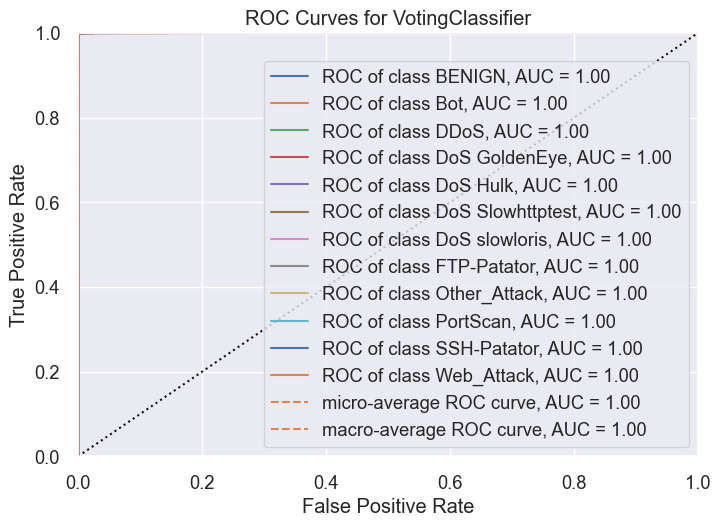

<Axes: title={'center': 'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [59]:

viz = ROCAUC(
    voting_model,
    classes=le.classes_,
    micro=True,
    macro=True
)

viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()


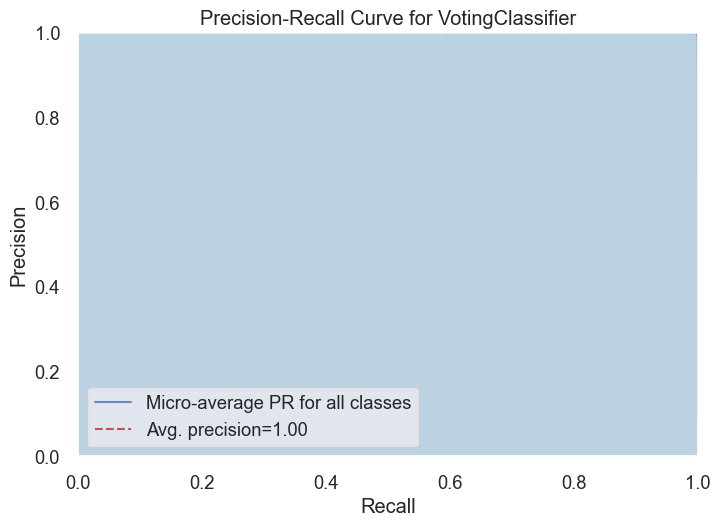

<Axes: title={'center': 'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
viz = PrecisionRecallCurve(voting_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()


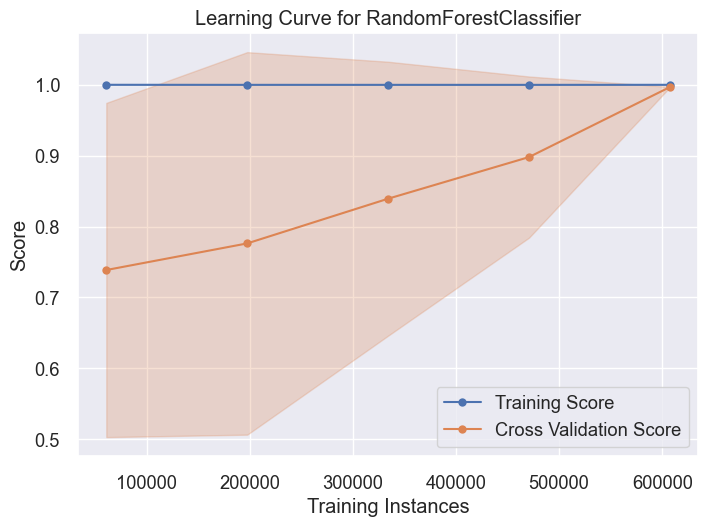

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
viz = LearningCurve(
    best_models["RandomForest"],
    cv=StratifiedKFold(3),
    scoring="f1_macro",
    n_jobs=-1
)

viz.fit(X_clf, y_clf)
viz.show()


In [69]:
#Per confronto, si rieesgue il model ensembling su random forest e logistic regression che hanno una correlazione minore
voting_model_rf_lr = VotingClassifier(
    estimators=[
        ("rf", best_models["RandomForest"]),
        ("lr", LogisticRegression(
            random_state=42,
            max_iter=1000,
            n_jobs=-1
        ))
    ],
    voting="soft",
    n_jobs=-1
)

voting_model_rf_lr.fit(x_train, y_train)

y_pred_voting = voting_model_rf_lr.predict(x_test)

print("Voting Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Voting F1_macro:", f1_score(y_test, y_pred_voting, average="macro"))

Voting Accuracy: 0.9975692729766804
Voting F1_macro: 0.9924006786099616


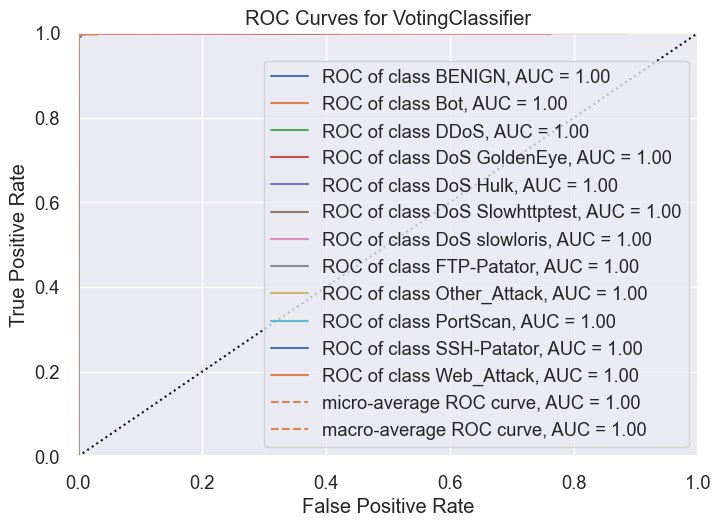

<Axes: title={'center': 'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
viz = ROCAUC(
    voting_model_rf_lr,
    classes=le.classes_,
    micro=True,
    macro=True
)

viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()


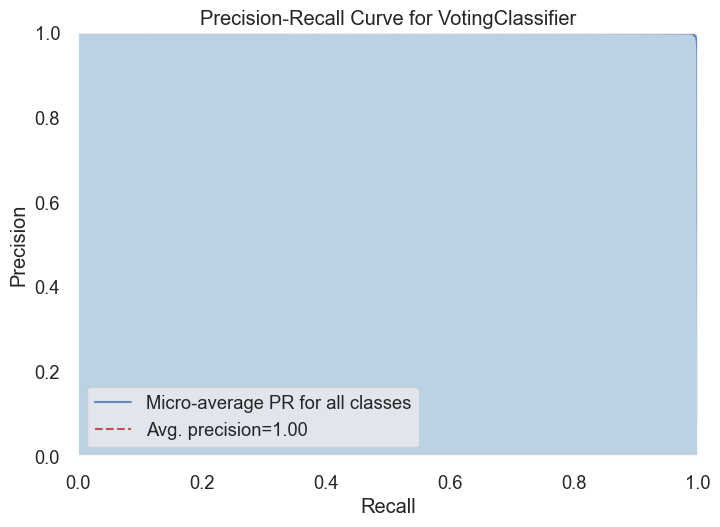

<Axes: title={'center': 'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
viz = PrecisionRecallCurve(voting_model_rf_lr)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()


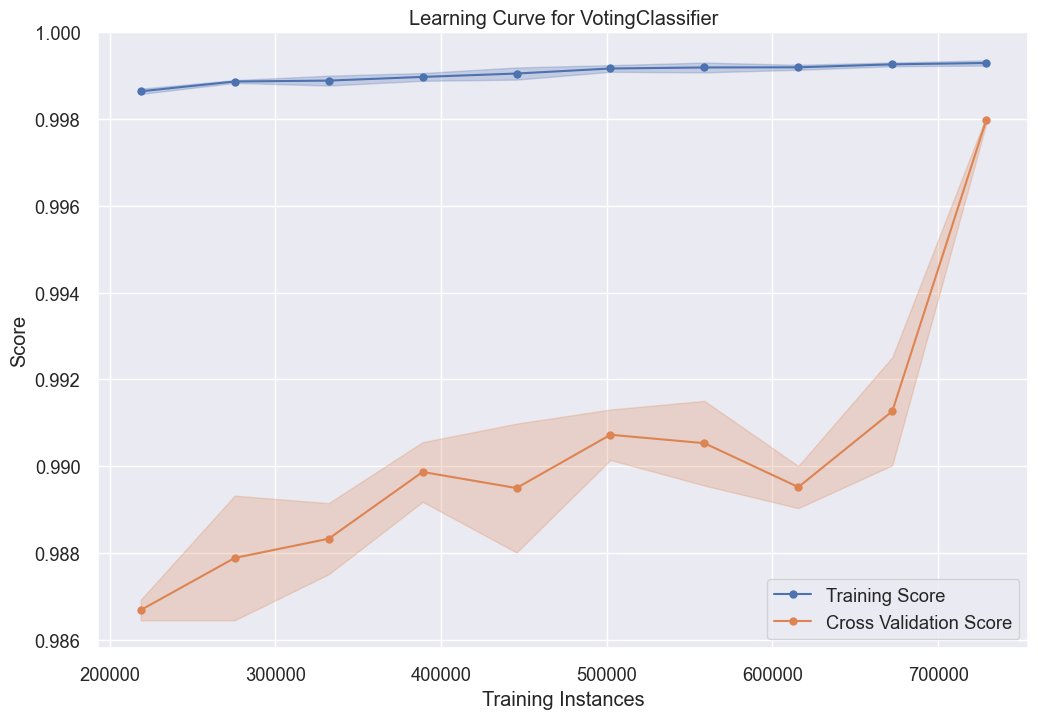

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [70]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    voting_model_rf_lr,
    cv=cv,
    scoring="f1_weighted",
    train_sizes=sizes,
    n_jobs=-1
)

visualizer.fit(X_clf, y_clf)
visualizer.show()